In [37]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from IntegratedGradients import *

# Using UCI Iris data

In [28]:
X = np.array([[float(j) for j in i.rstrip().split(",")[:-1]] for i in open("iris.data").readlines()][:-1])
Y = np.array([0 for i in range(100)] + [1 for i in range(50)])

# Using keras Model API

Running integrated_gradients is easy. You can wrap it around your keras Model instance.

In [3]:
from keras.layers import Input, Dense
from keras.models import Model

Step 1: Train a model.

In [ ]:
_input = Input(shape=[4])
probs = Dense(1, activation='sigmoid')(_input)

model1 = Model(inputs=_input, outputs=probs)
model1.compile(optimizer='sgd', loss='binary_crossentropy') 

Step 2: Fit the model.

In [4]:
model1.fit(X, Y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0)

Step 3: Wrap it with integrated_gradients.

In [12]:
ig = integrated_gradients(model1)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Step 4: Call **explain()** on the integrated_gradients instance with a sample to explain

In [13]:
ig.explain(X[0], num_steps=1000)

array([-0.14335335, -0.36171792,  0.12336462,  0.00727533])

# Using Sequential Model

The exact ame thing applies to keras Sequential models.

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation

Step 1: Train a model.

In [15]:
model2 = Sequential([
    Dense(1, input_dim=4),
    Activation('sigmoid'),
])
model2.compile(optimizer='sgd', loss='binary_crossentropy')

Step 2: Fit the model.

In [16]:
model2.fit(X, Y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0)

Step 3: Wrap it with integrated_gradients.

In [26]:
ig = integrated_gradients(model2)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Step 4: Explain a sample

In [29]:
ig.explain(X[0], num_steps=1000)

array([-0.28339713, -0.24795483,  0.11477474,  0.01710135])

# Using CNN on MNIST with 10 outputs

Of course you can do this on a CNN with multiple outputs 

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.core import Activation

Step 0: Get the data

In [48]:
# MNIST DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../notebooks/MNIST_data/", one_hot=True)

X = np.expand_dims(mnist.train._images.reshape(55000,28, 28), 3)
Y = mnist.train._labels

Extracting ../notebooks/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-labels-idx1-ubyte.gz


Step 1: Train a model.

In [49]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1))) # (28, 28, 1) for tf and (1, 28, 28) for theano
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation='softmax'))
model3.compile(optimizer='sgd', loss='categorical_crossentropy')

Step 2: Fit the model.

In [50]:
model3.fit(X, Y, epochs=15, batch_size=128, verbose=0)

Step 3: Wrap it with integrated_gradients.

In [51]:
ig = integrated_gradients(model3)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Step 4: Explain a sample with respect to each output channel.

Truth     : 6
Prediction: 6


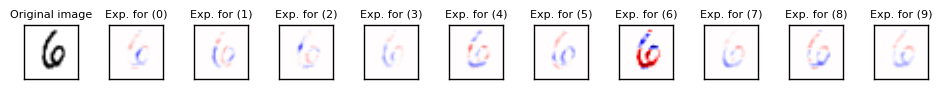

In [75]:
# Randomly choose a sample to explain. 
# Get the true label and a prediction associated with it.
index = np.random.randint(55000)
print "Truth     :", np.argmax(Y[index])
print "Prediction:", np.argmax(model3.predict(X[index:index+1])[0])

# Plot the true image.
plt.figure(figsize=(9.5,1))
plt.subplot(1,11,1)
plt.imshow(X[index][:,:,0], cmap="Greys")
plt.xticks([],[])
plt.yticks([],[])
plt.title("Original image", fontsize=8)

# Generate explanation with respect to each of 10 output channels.
exs = []
for i in range(1,11):
    exs.append(ig.explain(X[index], outc=i-1))
exs = np.array(exs)

# Plot them
th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
for i in range(1,11):
    ex = exs[i-1]
    plt.subplot(1,11,1+i)
    plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
plt.tight_layout()
plt.savefig("../notebooks/figures/"+str(index)+".png")
plt.show()